In [80]:
# import libraries
from numpy import mean
from numpy import std
from numpy import hstack
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split

# reading csv files
df =  pd.read_csv('adult.data', sep=",", header=None, skipinitialspace=True)
df2 = pd.read_csv('adult.test', sep=",", header=None, skipinitialspace=True)

# Join the data and test files together
df = pd.concat([df, df2])

# Shuffle the rows
df = df.sample(frac=1).reset_index(drop=True)

# Replace all of ? with None
df = df.replace(['?'], [None])
# Drop all rows with None in them
df = df.dropna(axis=0)

# Check no None values remain
df.isnull().sum()

#Adding column headers to our data 
df.columns = ["Age", "Workclass", "Fnlwgt", "Education", "Education-num", "Marital-status", "Occupation", "Relationship", "Race", "Sex", "Capital-gain", "Capital-loss", "Hours-per-week", "Native-country", "Income"]
# Workclass, Fnlwgt, Race and Native-country are not worth using.
# Education = Education num, so drop Education
df = df.drop(columns=['Workclass', 'Race', 'Fnlwgt', 'Native-country', 'Education'])


In [81]:
#Numerically encoding occupation: Occupaiton is grouped into white collar and blue collar 
occupation_mapping_dict = {
    "Tech-support" : 0,
    "Craft-repair" : 1, 
    "Other-service" : 1, #Wasn't sure about blue or white collar for other services 
    "Sales" : 0, 
    "Exec-managerial" : 0, 
    "Prof-specialty" : 0, 
    "Handlers-cleaners" : 1, 
    "Machine-op-inspct" : 1, 
    "Adm-clerical" : 0, 
    "Farming-fishing" : 1, 
    "Transport-moving" : 1, 
    "Priv-house-serv" : 1, 
    "Protective-serv" : 1, 
    "Armed-Forces" : 1
    }

df["Occupation"] = df["Occupation"].map(occupation_mapping_dict)


#Numerically encoding the sex variable 
sex_mapping_dict = {
    "Male" : 0,
    "Female" : 1
    }

df["Sex"] = df["Sex"].map(sex_mapping_dict)


#Encoding income variable
income_mapping_dict = {
    "<=50K" : 0,
    ">50K" : 1, 
    "<=50K." : 0, 
    ">50K." : 1
    }

df["Income"] = df["Income"].map(income_mapping_dict)
df


,Age,Education-num,Marital-status,Occupation,Relationship,Sex,Capital-gain,Capital-loss,Hours-per-week,Income
0,29,11,Separated,0,Unmarried,1,0,0,40,0
1,46,9,Married-civ-spouse,0,Husband,0,0,0,45,1
2,40,9,Married-civ-spouse,1,Husband,0,0,0,45,1
3,49,9,Married-civ-spouse,0,Husband,0,5013,0,40,0
4,46,4,Separated,1,Not-in-family,1,0,0,32,0
...,...,...,...,...,...,...,...,...,...,...
48837,29,9,Never-married,1,Not-in-family,0,0,1408,40,0
48838,30,4,Married-civ-spouse,1,Husband,0,0,0,40,0
48839,58,9,Divorced,0,Other-relative,1,0,0,32,0
48840,38,10,Married-civ-spouse,0,Husband,0,0,0,45,0


In [82]:
#Will now employ one-hot encoding for :  Marital Status and Relationship ; no order in their values
df = pd.get_dummies(df, columns = ['Relationship', 'Marital-status'])

,Age,Education-num,Occupation,Sex,Capital-gain,Capital-loss,Hours-per-week,Income,Relationship_Husband,Relationship_Not-in-family,...,Relationship_Own-child,Relationship_Unmarried,Relationship_Wife,Marital-status_Divorced,Marital-status_Married-AF-spouse,Marital-status_Married-civ-spouse,Marital-status_Married-spouse-absent,Marital-status_Never-married,Marital-status_Separated,Marital-status_Widowed
0,29,11,0,1,0,0,40,0,0,0,...,0,1,0,0,0,0,0,0,1,0
1,46,9,0,0,0,0,45,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,40,9,1,0,0,0,45,1,1,0,...,0,0,0,0,0,1,0,0,0,0
3,49,9,0,0,5013,0,40,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,46,4,1,1,0,0,32,0,0,1,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,29,9,1,0,0,1408,40,0,0,1,...,0,0,0,0,0,0,0,1,0,0
48838,30,4,1,0,0,0,40,0,1,0,...,0,0,0,0,0,1,0,0,0,0
48839,58,9,0,1,0,0,32,0,0,0,...,0,0,0,1,0,0,0,0,0,0
48840,38,10,0,0,0,0,45,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [88]:
# Split X and y
X = df.iloc[:, [0,1,2, 3, 4, 5, 6,8,9,10,11,12,13,14,15,16,17,18,19,20]]
y = df.iloc[:, [7]]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.20)

In [89]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier
#Create a Classifier
sgd_clf_7=RandomForestClassifier(n_estimators=100)

# Use cross-validation
from sklearn.model_selection import cross_val_predict
# Use 3-fold cross-validation to make “clean” predictions on our training data
train_data_predictions = cross_val_predict(sgd_clf_7, X_train, y_train.ravel(), cv=3)
train_data_predictions

from sklearn.metrics import confusion_matrix
# Show confusion matrix for our classifier’s predictions
confusion_matrix(y_train, train_data_predictions)


array([[24849,  2348],
       [ 3454,  5526]])

In [90]:
from sklearn.metrics import precision_score, recall_score

# Calculate and print precision and recall as percentages
print("Precision: " + str(round(precision_score(y_train, train_data_predictions)*100,1))+"%")
print("Recall: " + str(round(recall_score(y_train, train_data_predictions)*100,1))+"%")

Precision: 70.2%
Recall: 61.5%


In [91]:
# Use cross_val_predict to get our model's decision scores for each digit it has predicted
train_data_decision_scores = cross_val_predict(sgd_clf_7, X_train, y_train.ravel(), cv=3)

from sklearn.metrics import precision_recall_curve

# Obtain possible combinations of precisions, recalls, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_train, train_data_decision_scores)

<ipython-input-92-72f33edf7da5>:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


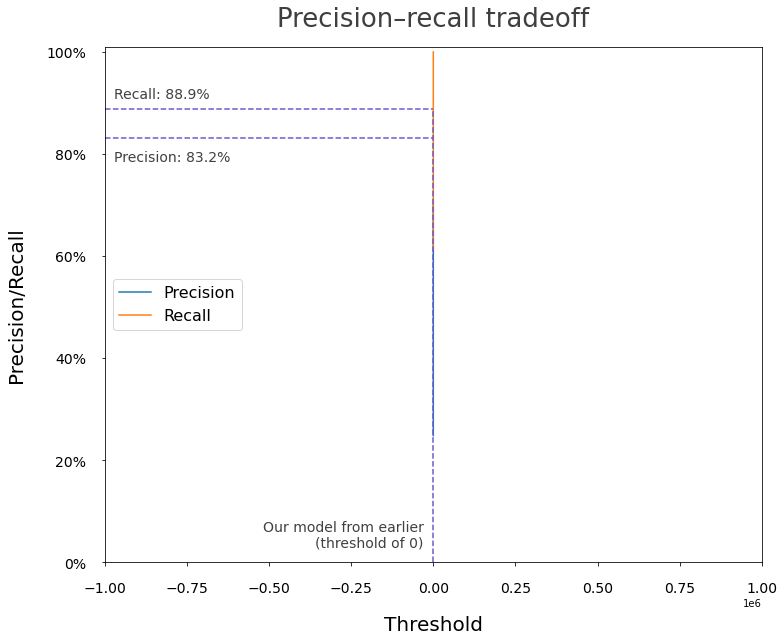

In [92]:
# Plotting Precision-Recall tradeoff

fig, ax = plt.subplots(figsize=(11,9))

# Plot decision and recall curves
ax.plot(thresholds, precisions[:-1], label="Precision")
ax.plot(thresholds, recalls[:-1], label="Recall")

# Add legend to distinguish lines
ax.legend(loc="center left", fontsize=16)

# Add x- and y-axis labels
ax.set_xlabel("Threshold", labelpad=20, fontsize=20)
ax.set_ylabel("Precision/Recall", labelpad=20, fontsize=20)

# Set appropriate x- and y-axis limits
ax.axis([-1000000,1000000,0,1.01])

# Add title
ax.text(x = 0, y = 1.05, s = "Precision–recall tradeoff", fontsize = 26, alpha = .75, ha="center")

# Remove gridlines
ax.grid(False)

# Set font sizes and padding for tick labels
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)

# Format y-axis to show percentages rather than decimals
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# Plot precision and recall when threshold is equal to zero
ax.plot([0, 0], [0.0, 0.889], "slateblue", linestyle="dashed")
ax.plot([-1000000, 0], [0.889, 0.889], "slateblue", linestyle="dashed")
ax.plot([-1000000, 0], [0.832, 0.832], "slateblue", linestyle="dashed")

# Add labels for these values
ax.text(x = -970000, y = 0.785, s = "Precision: 83.2%", fontsize = 14, alpha = .75, ha="left")
ax.text(x = -970000, y = 0.91, s = "Recall: 88.9%", fontsize = 14, alpha = .75, ha="left")
ax.text(x = -30000, y = 0.03, s = "Our model from earlier\n(threshold of 0)", fontsize = 14, alpha = .75, ha="right")

# Set tight layout
plt.tight_layout()


<ipython-input-93-773acff8f498>:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
<ipython-input-93-773acff8f498>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])


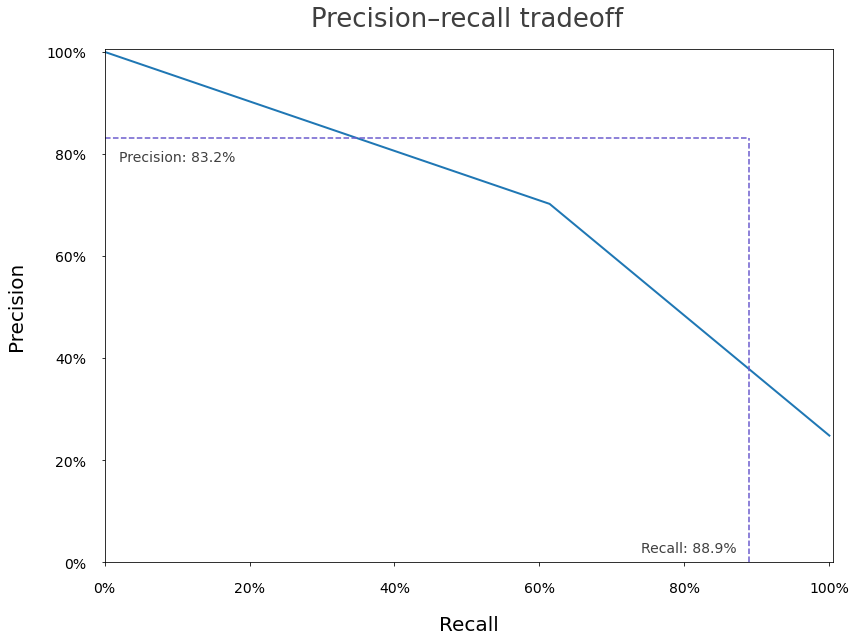

In [93]:
# Plotting precision-recall tradeoff

# Set up plotting area
fig, ax = plt.subplots(figsize=(12,9))

# Plot pairs of precision and recall for differing thresholds
ax.plot(recalls, precisions, linewidth=2)

# Add x- and y-axis labels
ax.set_xlabel("Recall", labelpad=20, fontsize=20)
ax.set_ylabel("Precision", labelpad=20, fontsize=20)

# Set x- and y-axis limits
ax.axis([0, 1.005, 0, 1.005])

# Remove gridlines
ax.grid(False)

# Set font sizes and padding for tick labels
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)

# Plot on the precision and recall for our SGD model with threshold of zeros
plt.plot([0.889, 0.889], [0., 0.832], "slateblue", linestyle="dashed")
plt.plot([0.0, 0.889], [0.832, 0.832], "slateblue", linestyle="dashed")

# Add title
ax.text(x = 0.5, y = 1.05, s = "Precision–recall tradeoff", fontsize = 26, alpha = .75, ha="center")

# Format axes to show percentages rather than decimals
x_vals = ax.get_xticks()
y_vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])

# Add labels for the values of precision and recall for our particular SGD model
ax.text(x = 0.02, y = 0.785, s = "Precision: 83.2%", fontsize = 14, alpha = .75, ha="left")
ax.text(x = 0.74, y = 0.02, s = "Recall: 88.9%", fontsize = 14, alpha = .75, ha="left")

# Set tight layout
plt.tight_layout()

# Save figure to .png image
plt.savefig('precision_recall_curve_2.png')

In [94]:
# Finding F1 score

from sklearn.metrics import f1_score

# Obtain and print F1 score as a percentage
print("F1 score: " + str(round(f1_score(y_train, train_data_predictions)*100,1))+"%")

F1 score: 65.6%


<ipython-input-95-cf96ce5bfc4f>:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
<ipython-input-95-cf96ce5bfc4f>:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])


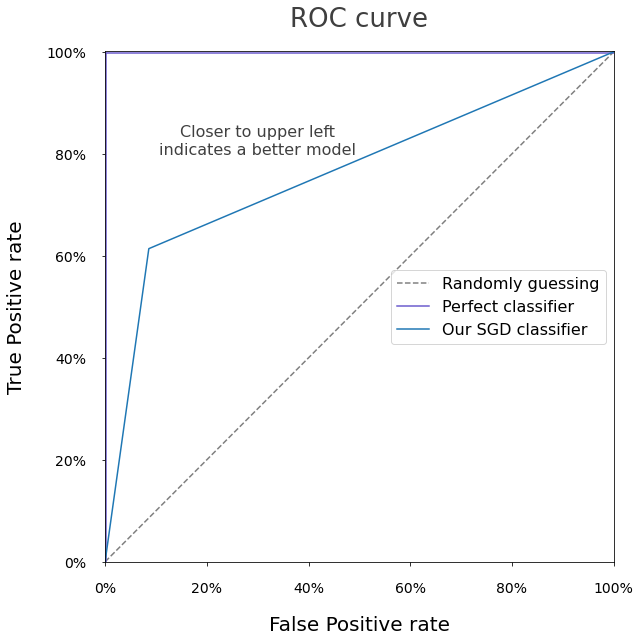

In [95]:
# Plotting ROC curve

from sklearn.metrics import roc_curve

# Set up plotting area
fig, ax = plt.subplots(figsize=(9,9))

# Obtain possible combinations of true/false positive rates and thresholds
fpr, tpr, thresholds = roc_curve(y_train, train_data_decision_scores)

# Remove gridlines
ax.grid(False)

# Set font sizes and padding for tick labels
ax.tick_params(axis="x", labelsize=14, pad=15)
ax.tick_params(axis="y", labelsize=14, pad=15)

# Plot random guess, 50/50 classifier
ax.plot([0,1], [0,1], "k--", alpha=0.5, label="Randomly guessing") 

# Plot perfect, omniscient classifier
ax.plot([0.002,0.002], [0,0.998], "slateblue", label="Perfect classifier")
ax.plot([0.001,1], [0.998,0.998], "slateblue")

# Plot our SGD classifier with threshold of zero
ax.plot(fpr, tpr, label="Our SGD classifier")

# Set x- and y-axis limits
ax.axis([-0.001,1.001,-0.001,1.001])

# Add legend to identify each of the three models
ax.legend(loc="center right", fontsize=16)

# Set x- and y-axis labels
ax.set_xlabel("False Positive rate", labelpad=20, fontsize=20)
ax.set_ylabel("True Positive rate", labelpad=20, fontsize=20)

# Format axes to show percentages rather than decimals
x_vals = ax.get_xticks()
y_vals = ax.get_yticks()
ax.set_xticklabels(['{:,.0%}'.format(x) for x in x_vals])
ax.set_yticklabels(['{:,.0%}'.format(y) for y in y_vals])

# Add title
ax.text(x = 0.5, y = 1.05, s = "ROC curve", fontsize = 26, alpha = .75, ha="center")

# Add annotation
ax.text(x = 0.3, y = 0.8, s = "Closer to upper left\nindicates a better model", fontsize = 16, alpha = .75, ha="center")

# Set tight layout
plt.tight_layout()

# Save figure to .png image
plt.savefig('roc_curve_3.png')

In [96]:
# Obtaining AUC value

from sklearn.metrics import roc_auc_score

# Obtain and print AUC
print("Area Under Curve (AUC): " + str(round(roc_auc_score(y_train, train_data_predictions),3)))



Area Under Curve (AUC): 0.765


In [ ]:
# With ['Age', 'Education', 'Occupation', 'Race', 'Sex', 'Hours-per-week', 'Native-country']:
# Area Under Curve (AUC): 0.687
# F1 score: 53.4%
# Precision: 61.4%
# Recall: 47.2%
# Confusion matrix:
# array([[24582,  2656],
#        [ 4719,  4220]])